<a href="https://colab.research.google.com/github/BMateusSs/Projeto-PISI3/blob/main/exploratory_analysis_wine_quality_description.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install dependencies as needed:
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "winemag-data-130k-v2.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "zynicide/wine-reviews",
  file_path
)

<ipython-input-1-1f7aa660e4cc>:9: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


100%|██████████| 16.4M/16.4M [00:00<00:00, 49.9MB/s]

Extracting zip of winemag-data-130k-v2.csv...


Limpeza dos dados

In [2]:
import pandas as pd

# Assumindo que 'df' já foi carregado e contém a coluna 'points'
# (A etapa de carregamento usando kagglehub parece já carregar essa coluna)

# Remova linhas onde 'region_1' ou 'points' são NaN
# Isso garante que ambas as colunas essenciais para o balanceamento e categorização estejam presentes
df = df.dropna(subset=["region_1", "points"])

# Selecione as colunas relevantes para o balanceamento E a coluna de qualidade
# Mantenha 'region_1' para o balanceamento, 'description' para o processamento futuro, e 'points' para a categorização de qualidade.
df = df[["region_1", "description", "points"]]
df.head()

# 1. Identificar as 10 regiões com mais registros
top_10_regions = df['region_1'].value_counts().nlargest(10).index.tolist()

# 2. Filtrar o DataFrame para incluir apenas as top 10 regiões
df_top_10 = df[df['region_1'].isin(top_10_regions)]

# 3. Identificar a contagem mínima entre as top 10 regiões
min_count = df_top_10['region_1'].value_counts().min()

print(f"As 10 regiões com mais registros são: {top_10_regions}")
print(f"A contagem mínima de registros entre as top 10 regiões é: {min_count}")

# 4. Amostrar cada uma das top 10 regiões para ter a contagem mínima
sampled_dfs = []
for region in top_10_regions:
    df_region = df_top_10[df_top_10['region_1'] == region]
    # Amostra aleatoriamente 'min_count' registros para cada região
    df_sampled = df_region.sample(n=min_count, random_state=42) # random_state para reprodutibilidade
    sampled_dfs.append(df_sampled)

# Concatenar os DataFrames amostrados de volta em um único DataFrame
df_balanced = pd.concat(sampled_dfs)

# Opcional: Embaralhar as linhas do DataFrame resultante
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Mostrar as primeiras linhas do DataFrame balanceado, incluindo 'points'
print("\nPrimeiras linhas do DataFrame balanceado:")
print(df_balanced.head()) # Mostra todas as colunas, incluindo 'points'

# Verificar a contagem de registros por região no DataFrame balanceado
print("\nContagem de registros por região no DataFrame balanceado:")
print(df_balanced['region_1'].value_counts())

# Atualize o DataFrame principal 'df' com o DataFrame balanceado
df = df_balanced

# Agora, aplique a categorização da coluna 'points' em 10 regiões
coluna_qualidade = 'points'
num_regioes = 10
rotulos_regioes = [str(i) for i in range(1, num_regioes + 1)]

# Use pd.qcut para dividir a coluna 'points' em 10 quantis e substituir os valores
df[coluna_qualidade] = pd.qcut(
    df[coluna_qualidade],
    q=num_regioes,
    labels=rotulos_regioes,
    duplicates='drop' # Lida com valores duplicados em pontos de corte
)

# Verifique o resultado final da coluna 'points'
print(f"\nPrimeiras linhas do DataFrame com a coluna '{coluna_qualidade}' transformada em regiões:")
print(df[[coluna_qualidade, 'region_1', 'description']].head())

print(f"\nContagem de vinhos por região de qualidade na coluna '{coluna_qualidade}' após a transformação:")
print(df[coluna_qualidade].value_counts().sort_index())
df.head()

As 10 regiões com mais registros são: ['Napa Valley', 'Columbia Valley (WA)', 'Russian River Valley', 'California', 'Paso Robles', 'Mendoza', 'Willamette Valley', 'Alsace', 'Champagne', 'Barolo']
A contagem mínima de registros entre as top 10 regiões é: 1599

Primeiras linhas do DataFrame balanceado:
               region_1                                        description  \
0                Barolo  Enticing aromas of red rose, wild red berry an...   
1                Barolo  Underbrush, grilled porcini, red berry and gri...   
2           Napa Valley  A lovely Cabernet, richly attractive and deepl...   
3  Columbia Valley (WA)  This new winery knocks it out of the park with...   
4           Paso Robles  This untraditional blend works well, with the ...   

   points  
0      90  
1      89  
2      95  
3      91  
4      90  

Contagem de registros por região no DataFrame balanceado:
region_1
Barolo                  1599
Napa Valley             1599
Columbia Valley (WA)    1599
Pa

,region_1,description,points
0,Barolo,"Enticing aromas of red rose, wild red berry an...",6
1,Barolo,"Underbrush, grilled porcini, red berry and gri...",5
2,Napa Valley,"A lovely Cabernet, richly attractive and deepl...",10
3,Columbia Valley (WA),This new winery knocks it out of the park with...,7
4,Paso Robles,"This untraditional blend works well, with the ...",6


In [3]:
import nltk
from nltk.corpus import stopwords
import string

# Baixe as stopwords se ainda não as tiver
try:
    stopwords.words('portuguese')
except LookupError:
    nltk.download('stopwords')

stop_words = set(stopwords.words('portuguese'))

def clean_text(text):
    # Converter para lowercase
    text = text.lower()
    # Remover pontuação
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remover stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Aplicar a função de limpeza na coluna 'description'
df['description'] = df['description'].apply(clean_text)
df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,region_1,description,points
0,Barolo,enticing aromas of red rose wild red berry and...,6
1,Barolo,underbrush grilled porcini red berry and grill...,5
2,Napa Valley,lovely cabernet richly attractive and deeply f...,10
3,Columbia Valley (WA),this new winery knocks it out of the park with...,7
4,Paso Robles,this untraditional blend works well with the l...,6


In [ ]:
from sentence_transformers import SentenceTransformer

# Experimente com um modelo diferente:
model = SentenceTransformer('all-mpnet-base-v2')
embeddings = model.encode(df['description'].tolist(), show_progress_bar=True)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
emb_pca = pca.fit_transform(embeddings)

In [ ]:
import umap
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
umap_2d = reducer.fit_transform(emb_pca)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_2d = tsne.fit_transform(embeddings)


<ipython-input-15-cff5342ebcc0>:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_qualidades)) # Obter um mapa de cores (viridis é bom para gradientes)


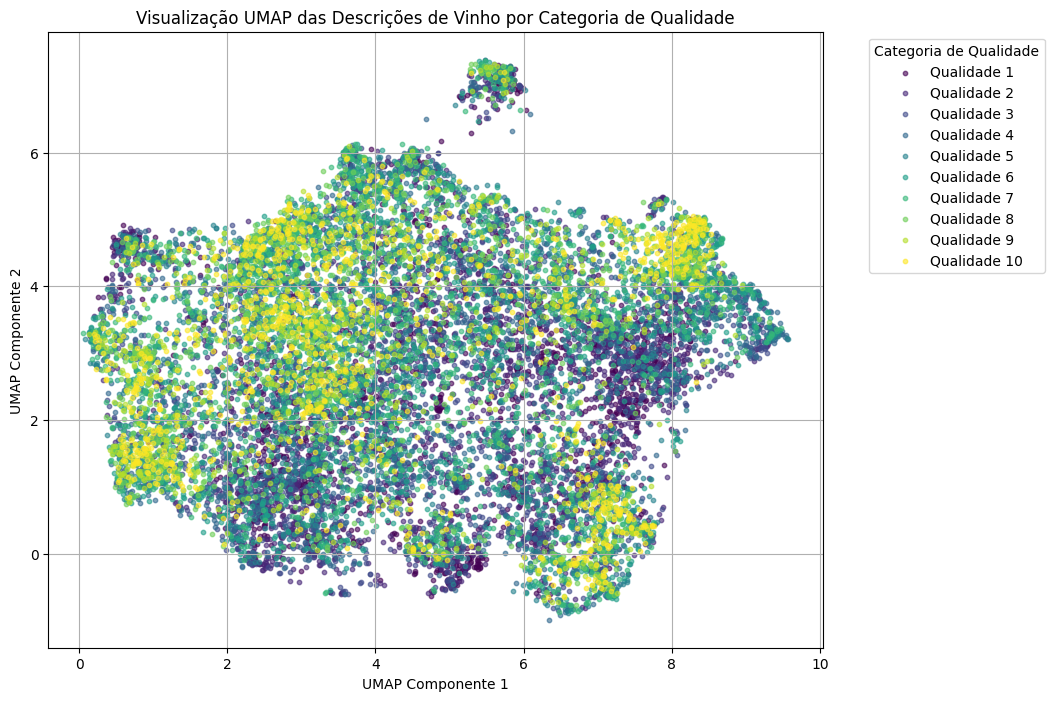

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assumindo que você já gerou o 'umap_2d' (ou 'tsne_2d') e tem seu 'df'
# Certifique-se de que 'umap_2d'/'tsne_2d' e 'df' (que agora contém as categorias de qualidade) estão disponíveis

# Escolha qual visualização usar (UMAP ou t-SNE)
visualizacao_2d = umap_2d # Use UMAP se preferir
# visualizacao_2d = tsne_2d # Use t-SNE se preferir

# Extrair as coordenadas X e Y da visualização escolhida
x_coords = visualizacao_2d[:, 0]
y_coords = visualizacao_2d[:, 1]

# Obter os rótulos das categorias de qualidade
# A coluna de qualidade agora contém os rótulos '1', '2', ..., '10'
qualidade_labels = df['points'] # Use o nome da coluna de qualidade

# Criar o gráfico de dispersão
plt.figure(figsize=(10, 8)) # Define o tamanho da figura

# Plotar os pontos. Usando a coluna de qualidade para colorir.
# Para colorir por categoria, você pode iterar sobre as categorias únicas ou usar uma biblioteca como Seaborn
# Uma forma simples com matplotlib é plotar cada categoria separadamente:
unique_qualidades = sorted(qualidade_labels.unique().tolist(), key=int) # Obter as categorias únicas e ordenar numericamente
colors = plt.cm.get_cmap('viridis', len(unique_qualidades)) # Obter um mapa de cores (viridis é bom para gradientes)
# Ou use 'tab10' ou 'tab20' se preferir cores distintas

for i, qualidade_categoria in enumerate(unique_qualidades):
    # Filtrar os dados para a categoria de qualidade atual
    mask = qualidade_labels == qualidade_categoria
    plt.scatter(
        x_coords[mask],
        y_coords[mask],
        label=f'Qualidade {qualidade_categoria}', # Rótulo da legenda
        color=colors(i),
        s=10, # Tamanho dos pontos
        alpha=0.6 # Transparência
    )

# Adicione um título apropriado com base na visualização usada
if 'umap_2d' in locals() and visualizacao_2d is umap_2d:
     plt.title('Visualização UMAP das Descrições de Vinho por Categoria de Qualidade')
     plt.xlabel('UMAP Componente 1')
     plt.ylabel('UMAP Componente 2')
elif 'tsne_2d' in locals() and visualizacao_2d is tsne_2d:
     plt.title('Visualização t-SNE das Descrições de Vinho por Categoria de Qualidade')
     plt.xlabel('t-SNE Componente 1')
     plt.ylabel('t-SNE Componente 2')


plt.legend(title='Categoria de Qualidade', bbox_to_anchor=(1.05, 1), loc='upper left') # Adiciona a legenda fora do gráfico
plt.grid(True)
plt.show() # Mostra o gráfico